<h1> 
    <font color='steelblack'> <center>Mise en place d'un modèle de prédiction de Coronavirus : 
        <font color='green'>Le Coronaver</font> </center> </font>
</h1>
<h3> <center><i>Jean-Martial TAGRO : Data Scientist </i> </center> </h3>

# I. Objectif Mesurable

L'objet de l'étude est de proposer un modèle qui prédit à  <b>50  %  de la F1 - Score et 70 % de recall</b> l'absence ou la présence du Covid-19 (Coronavirus) chez un patient en fonctions des données cliniques.

In [37]:
# Importations
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, MultiLabelBinarizer,\
                                    MinMaxScaler, StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.feature_selection import chi2, SelectFromModel, SelectKBest, VarianceThreshold, RFECV, f_classif
#from sklearn.feature_extraction import 

---

In [4]:
# get dataset
data = pd.read_excel(os.getcwd()+'/dataset.xlsx')

In [13]:
# get dataset et check size
corona = pd.read_excel(os.getcwd()+'/dataset.xlsx')
corona.shape

(5644, 111)

In [14]:
# to set pandas display 111 rows entirely
pd.set_option('display.max_row', 111)
pd.set_option('display.max_column', 111)

---

# II. EDA - Exploratory Data Analysis

## Objectif :
- Comprendre du mieux possible nos données (un petit pas en avant vaut mieux qu'un grand pas en arriere)
- Développer une premiere stratégie de modélisation 


## Checklist de base
#### Analyse de Forme :
- **variable target** : SARS-Cov-2 exam result
- **lignes et colonnes** : ( 5644, 111 )
- **types de variables** : Nombres de var par type : Numerical (float) : 70 / Categorical (object + int) : 41
- **Analyse des valeurs manquantes** : Beaucoup de NaN : plus de la moitié des var ont >90% de NaN : 
2 groupes de var : 76% NaN --> Test viral  ||| 89% NaN --> Taux sanguins

    
#### Analyse de Fond :
- **Visualisation de la target** : negatives : 5086 / positives : 558 --> 10% de cas positifs
    
    
    
- **Signification des variables** :

<br> A. VAR QUANTITATIVES :
- Variables continues : standardisées, dont 2 var de test sanguins : Basophilis, Eosinophilis asymétriques
- Variable discrète : Patient age quantile : pas d'information s'il y a eu transformation (echelle,...) en amont; car entre 0 et 20 ans (bizarre) --> on SUPOSE que [0-5] --> [0-20ans] : Difficile à interpréter.

<br> B. VAR QUALITATIVES :
- Variables qualitatiques toutes binaires, type viral, Rhinovirus/Anterovirus semble importante. Toutes les autres sont rarement détectées.


- **Relation Variables / Target** :

- Target / Blood : Il semblerait que les Platelets, Leukocytes et Monocytes soient liés au Covod-19 : --> Hypotèse à tester 

- Target / Age : Les personnes moins agées sont-elles moins susceptibles d'attraper le Covid ? Pas sûr car les tests cliniques ont montrés qu'il y a pas mal d'enfants ayant eu le Covid. Et selon l'analyse de la signification des variables, on ne connait pas vraiment l'age ! 

- Target / Viral : Evidemment, il est rare de voir une personne avec 2 virus en même temps, mais c'est tout à fait possible. le Rhinovirus/Enterovirus est beaucoup présent chez les personnes OBSERVÉES qui n'ont pas le covid. Ça peut-être rien à voir avec le Covid et simplement du à un effet de hasard : la région des prélèvements est pétrie de ce virus (Rhinovirus/Enterovirus).
    
    
## Analyse plus détaillée

- **Relation Variables / Variables** : ok, (...)
    

- **NaN analyse** :

### hypotheses nulle (H0): 

- Les taux de Platelets, Leukocytes et Monocytes sont différents chez les individus atteint du Covid-19 
- ---> H0 : Les taux de Platelets, Leukocytes et Monocytes SONT EGAUX chez les toutes les personnes, atteintes ou non du Coronavirus.
- ---> H1 : Hypothèse Complémentaire

- CONCLUSION DU TEST ===> H0 rejetée


### 1. Analyse de la forme

In [15]:
corona.shape

(5644, 111)

In [16]:
# show 1st rows dataset
corona.head()

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Serum Glucose,Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Mycoplasma pneumoniae,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Neutrophils,Urea,Proteina C reativa mg/dL,Creatinine,Potassium,Sodium,"Influenza B, rapid test","Influenza A, rapid test",Alanine transaminase,Aspartate transaminase,Gamma-glutamyltransferase,Total Bilirubin,Direct Bilirubin,Indirect Bilirubin,Alkaline phosphatase,Ionized calcium,Strepto A,Magnesium,pCO2 (venous blood gas analysis),Hb saturation (venous blood gas analysis),Base excess (venous blood gas analysis),pO2 (venous blood gas analysis),Fio2 (venous blood gas analysis),Total CO2 (venous blood gas analysis),pH (venous blood gas analysis),HCO3 (venous blood gas analysis),Rods #,Segmented,Promyelocytes,Metamyelocytes,Myelocytes,Myeloblasts,Urine - Esterase,Urine - Aspect,Urine - pH,Urine - Hemoglobin,Urine - Bile pigments,Urine - Ketone Bodies,Urine - Nitrite,Urine - Density,Urine - Urobilinogen,Urine - Protein,Urine - Sugar,Urine - Leukocytes,Urine - Crystals,Urine - Red blood cells,Urine - Hyaline cylinders,Urine - Granular cylinders,Urine - Yeasts,Urine - Color,Partial thromboplastin time (PTT),Relationship (Patient/Normal),International normalized ratio (INR),Lactic Dehydrogenase,"Prothrombin time (PT), Activity",Vitamin B12,Creatine phosphokinase (CPK),Ferritin,Arterial Lactic Acid,Lipase dosage,D-Dimer,Albumin,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.02234,-0.517413,0.010677,0.102004,0.318366,-0.95079,-0.09461,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,-0.140648,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-0.619086,1.198059,-0.147895,2.089928,-0.305787,0.862512,negative,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [17]:
corona['SARS-Cov-2 exam result'].value_counts()

negative    5086
positive     558
Name: SARS-Cov-2 exam result, dtype: int64

float64    70
object     37
int64       4
dtype: int64

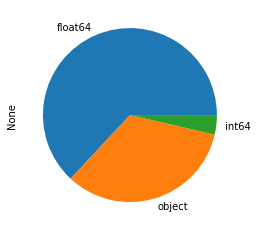

In [18]:
corona.dtypes.value_counts().plot.pie()
corona.dtypes.value_counts()

<AxesSubplot:>

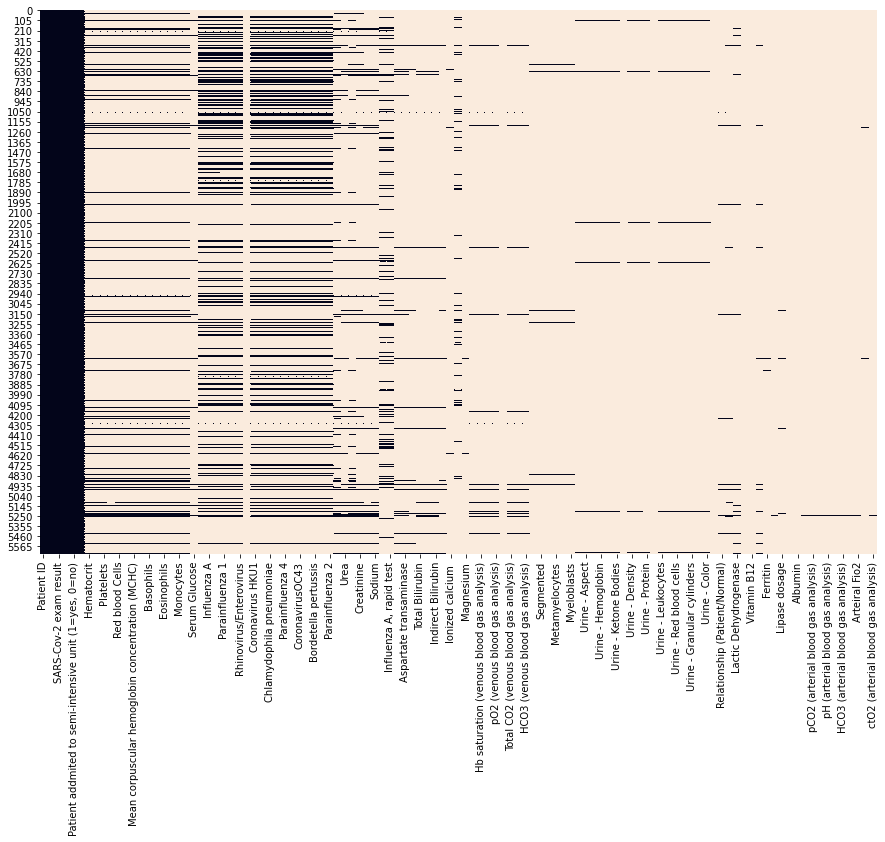

In [19]:
# analyse valeurs manquantes
plt.figure(figsize = (15,10))
sns.heatmap(corona.isna(), cbar=False)

In [20]:
# calcul de % NaN
(corona.isna().sum()/corona.shape[0]).sort_values(ascending=True)

Patient ID                                               0.000000
Patient age quantile                                     0.000000
SARS-Cov-2 exam result                                   0.000000
Patient addmited to regular ward (1=yes, 0=no)           0.000000
Patient addmited to semi-intensive unit (1=yes, 0=no)    0.000000
Patient addmited to intensive care unit (1=yes, 0=no)    0.000000
Influenza B                                              0.760099
Respiratory Syncytial Virus                              0.760099
Influenza A                                              0.760099
Rhinovirus/Enterovirus                                   0.760454
Inf A H1N1 2009                                          0.760454
CoronavirusOC43                                          0.760454
Coronavirus229E                                          0.760454
Parainfluenza 4                                          0.760454
Adenovirus                                               0.760454
Chlamydoph

### 1. Analyse de fond

#### Suppression des variables avec > 90% de valeurs manquantes

In [21]:
corona = corona[corona.columns[(corona.isna().sum()/corona.shape[0]) < 0.9]]   # eliminate > 90%
corona

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,"Influenza B, rapid test","Influenza A, rapid test"
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.022340,-0.517413,0.010677,0.102004,0.318366,-0.950790,-0.094610,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5639,ae66feb9e4dc3a0,3,positive,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5640,517c2834024f3ea,17,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5641,5c57d6037fe266d,4,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5642,c20c44766f28291,10,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

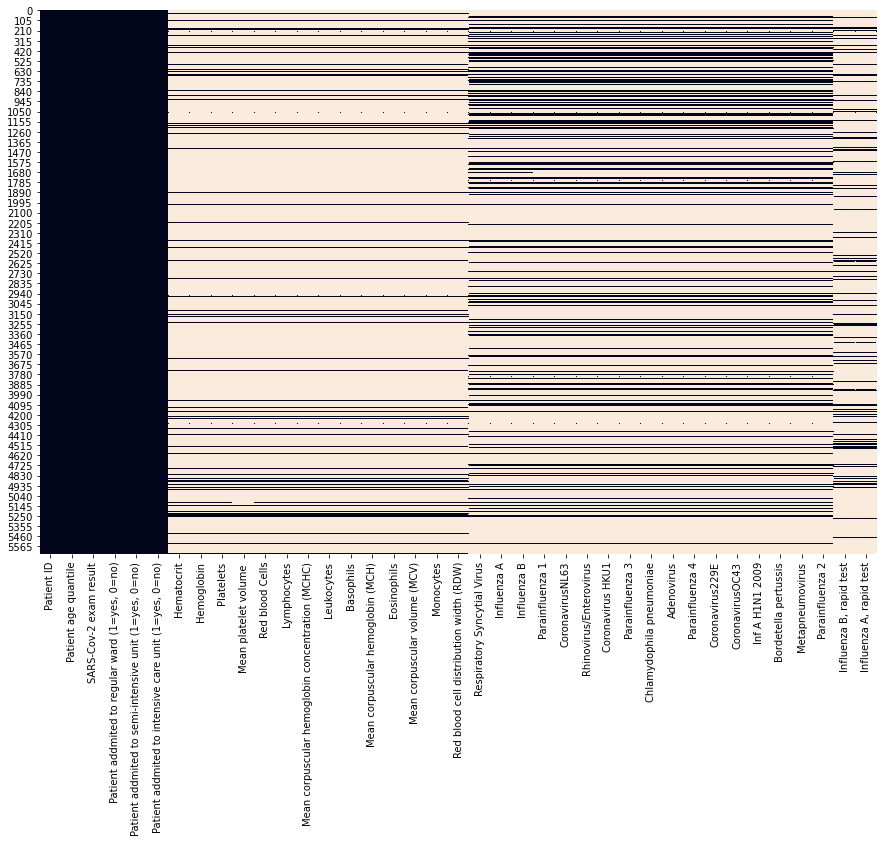

In [22]:
# analyse valeurs manquantes du dataset filtré
plt.figure(figsize = (15,10))
sns.heatmap(corona.isna(), cbar=False)

In [23]:
# Elimination de patientID qui ne sert à rien
corona.drop('Patient ID', axis=1, inplace=True)

In [24]:
corona.head()

,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,"Influenza B, rapid test","Influenza A, rapid test"
0,13,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17,negative,0,0,0,0.236515,-0.02234,-0.517413,0.010677,0.102004,0.318366,-0.95079,-0.09461,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative
2,8,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,NaN,NaN


#### Visualisation Target

In [25]:
corona['SARS-Cov-2 exam result'].value_counts() #to get % : normalize=True

negative    5086
positive     558
Name: SARS-Cov-2 exam result, dtype: int64

On voit que nos classes ne sont pas équilibrées dans ce problème, donc éviter l'accuracy comme métrique; d'où le choix du recall et de la F1 score.

#### Compréhension des variables - Histogramme des variables quantitives

/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

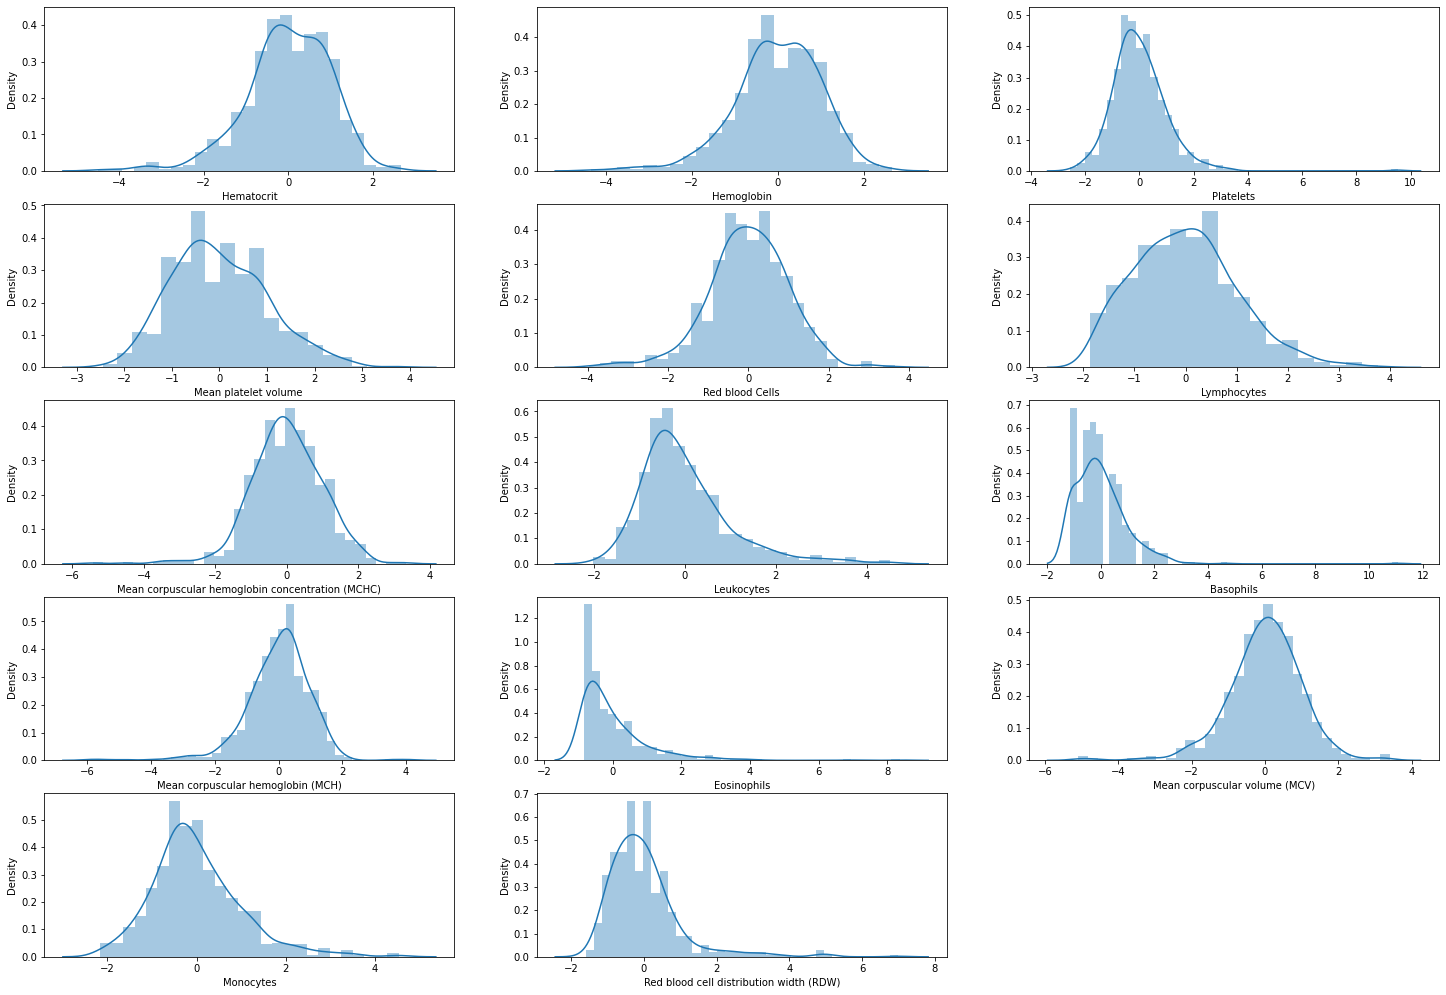

In [26]:
# get var float, int, object
plt.figure(figsize=(25,50))
for index, col in enumerate(corona.select_dtypes('float')):
    plt.subplot(14,3, index+1)
    #plt.hist(corona[col])
    sns.distplot(corona[col])
    index += 1

/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Patient age quantile', ylabel='Density'>

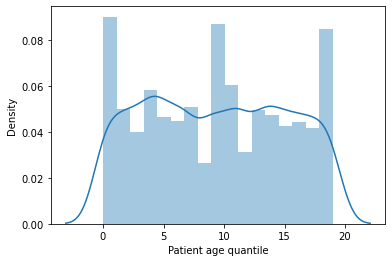

In [27]:
sns.distplot(corona['Patient age quantile'])

#### Compréhension des variables - Variables qualitatives
##### Analyse des catégories dans chaque variables qualitatives

In [49]:
for index, col in enumerate(corona.select_dtypes('object')):
    #print(corona[col].value_counts())
    print(f'{col:-<50} {corona[col].unique()}')

SARS-Cov-2 exam result---------------------------- ['negative' 'positive']
Respiratory Syncytial Virus----------------------- [nan 'not_detected' 'detected']
Influenza A--------------------------------------- [nan 'not_detected' 'detected']
Influenza B--------------------------------------- [nan 'not_detected' 'detected']
Parainfluenza 1----------------------------------- [nan 'not_detected' 'detected']
CoronavirusNL63----------------------------------- [nan 'not_detected' 'detected']
Rhinovirus/Enterovirus---------------------------- [nan 'detected' 'not_detected']
Coronavirus HKU1---------------------------------- [nan 'not_detected' 'detected']
Parainfluenza 3----------------------------------- [nan 'not_detected' 'detected']
Chlamydophila pneumoniae-------------------------- [nan 'not_detected' 'detected']
Adenovirus---------------------------------------- [nan 'not_detected' 'detected']
Parainfluenza 4----------------------------------- [nan 'not_detected' 'detected']
Coronavirus2

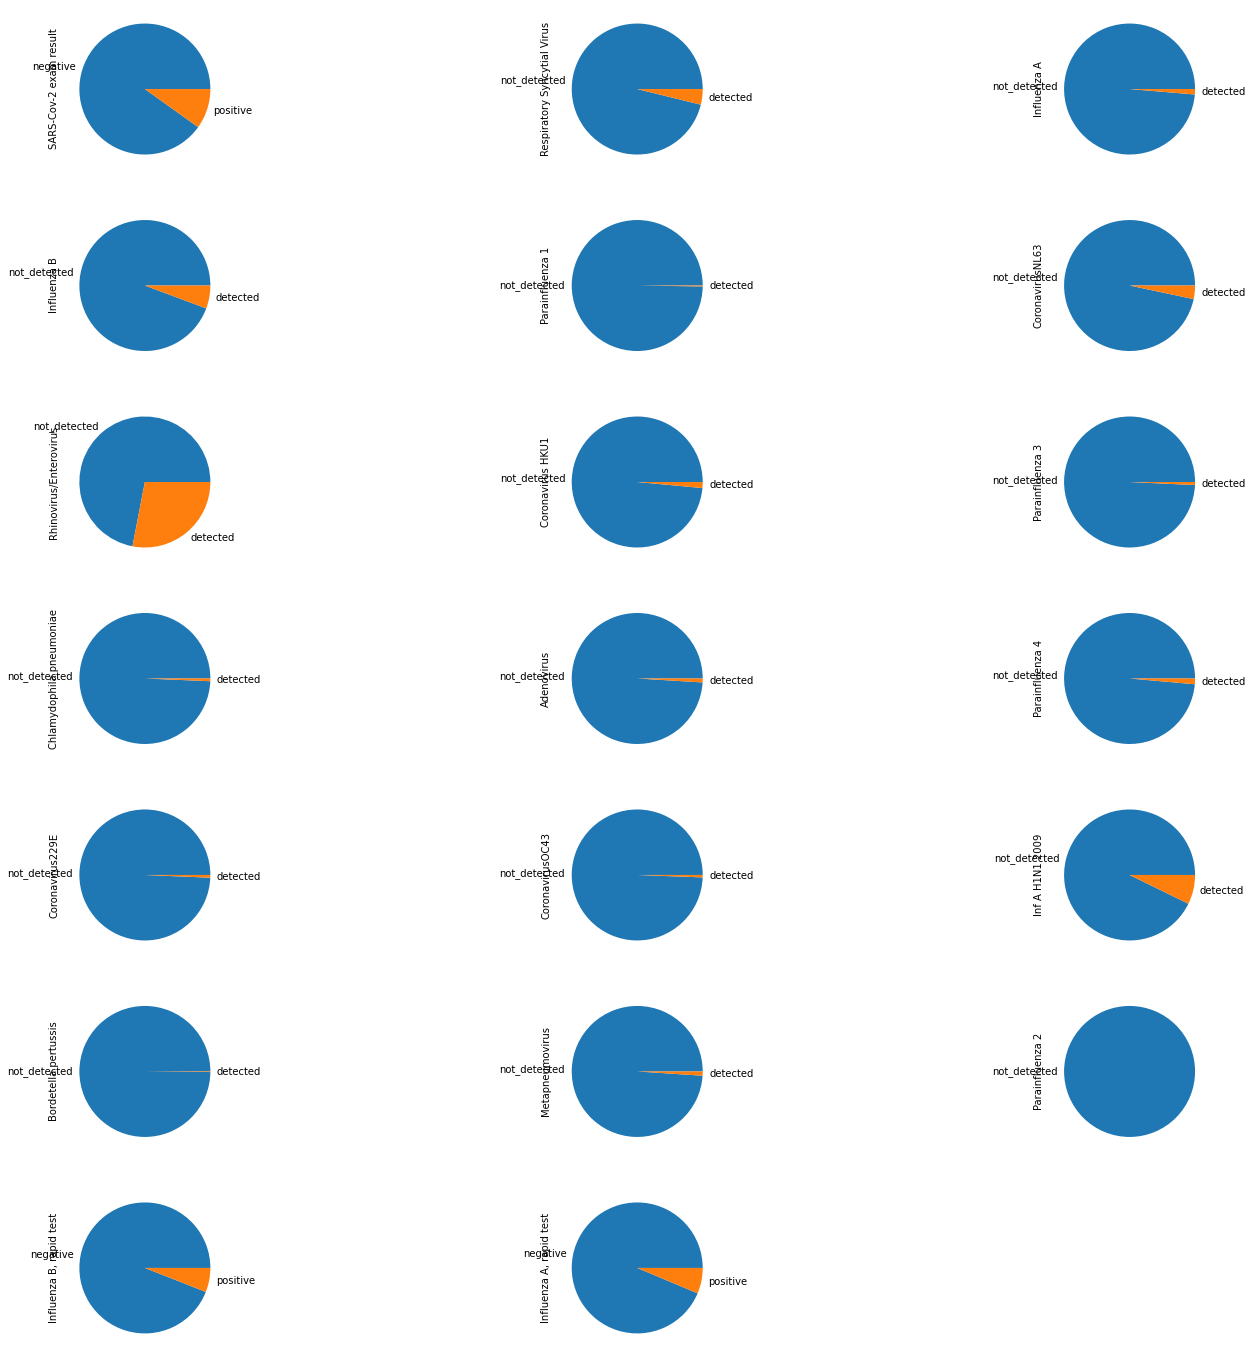

In [50]:
# affichage des proportion des categories pour chaque variable
plt.figure(figsize=(25,50))
for index, col in enumerate(corona.select_dtypes('object')):
    plt.subplot(14,3, index+1)
    corona[col].value_counts().plot.pie()
    index += 1

#### Création de sous ensembles Positifs / Négatifs au Covid-19

In [61]:
covid_neg = corona[corona['SARS-Cov-2 exam result'] == 'negative']
covid_pos = corona[corona['SARS-Cov-2 exam result'] == 'positive']

In [62]:
covid_pos.shape, covid_neg.shape

((558, 38), (5086, 38))

##### Création de sous ensembles de colonnes Blood / Viral

In [81]:
missing_rate = corona.isna().sum()/corona.shape[0]

In [82]:
viral_cols = corona.columns[(missing_rate > 0.76) & (missing_rate < 0.89)]
blood_cols = corona.columns[(missing_rate > 0.89) & (missing_rate < 0.9)]

### Relation Target / Blood : variables quantitatives continues

/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

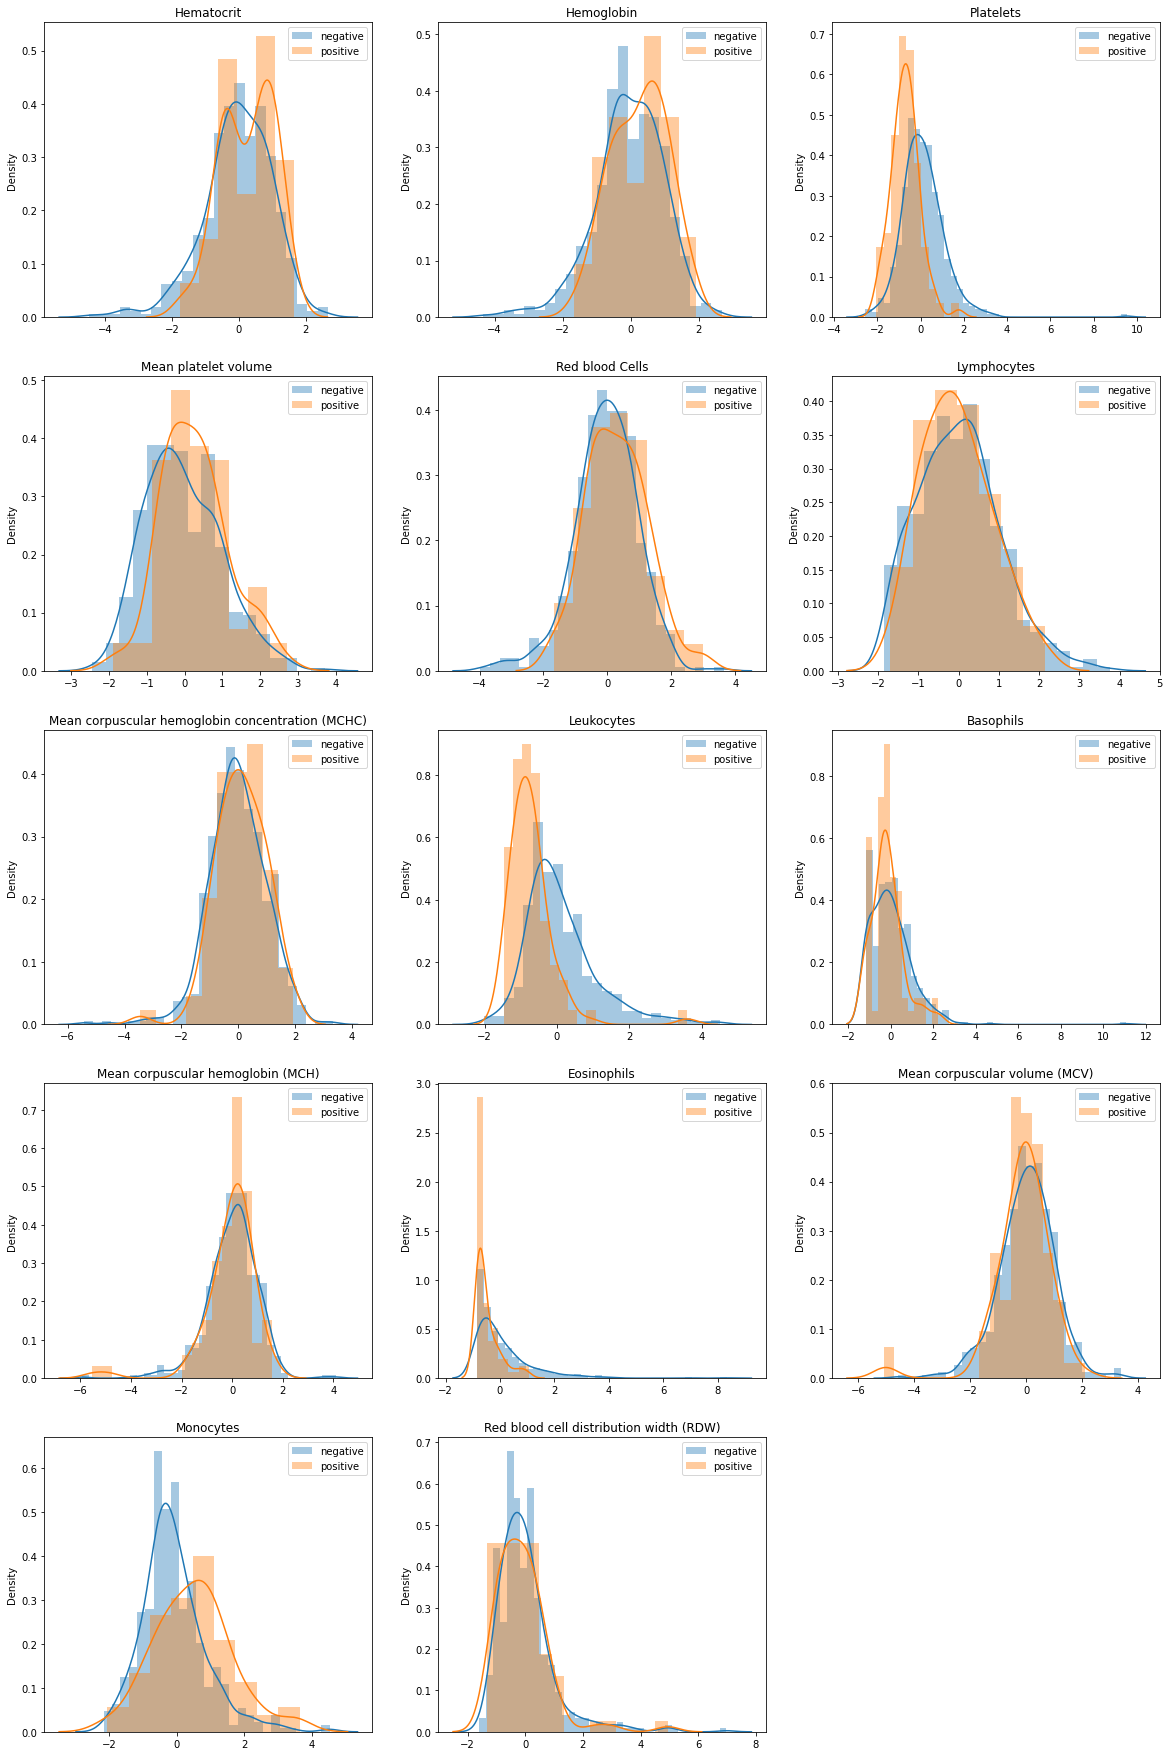

In [110]:
plt.figure(figsize=(20, 90))
for index, col in enumerate(blood_cols):
    plt.subplot(14,3, index+1)
    sns.distplot(x=covid_neg[col], label='negative')
    sns.distplot(x=covid_pos[col], label='positive')
    plt.legend()
    plt.title(col)
    index += 1

---

### Relation Target / Age : variable quantitative discrètes

<AxesSubplot:xlabel='Patient age quantile', ylabel='count'>

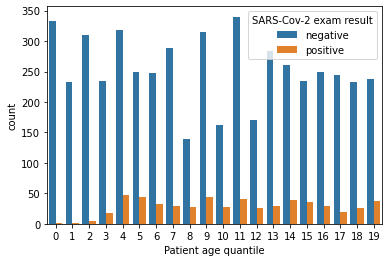

In [111]:
sns.countplot(x=corona['Patient age quantile'], hue=corona['SARS-Cov-2 exam result'], data=corona)

### Relation Target / Viral : variables qualitatives

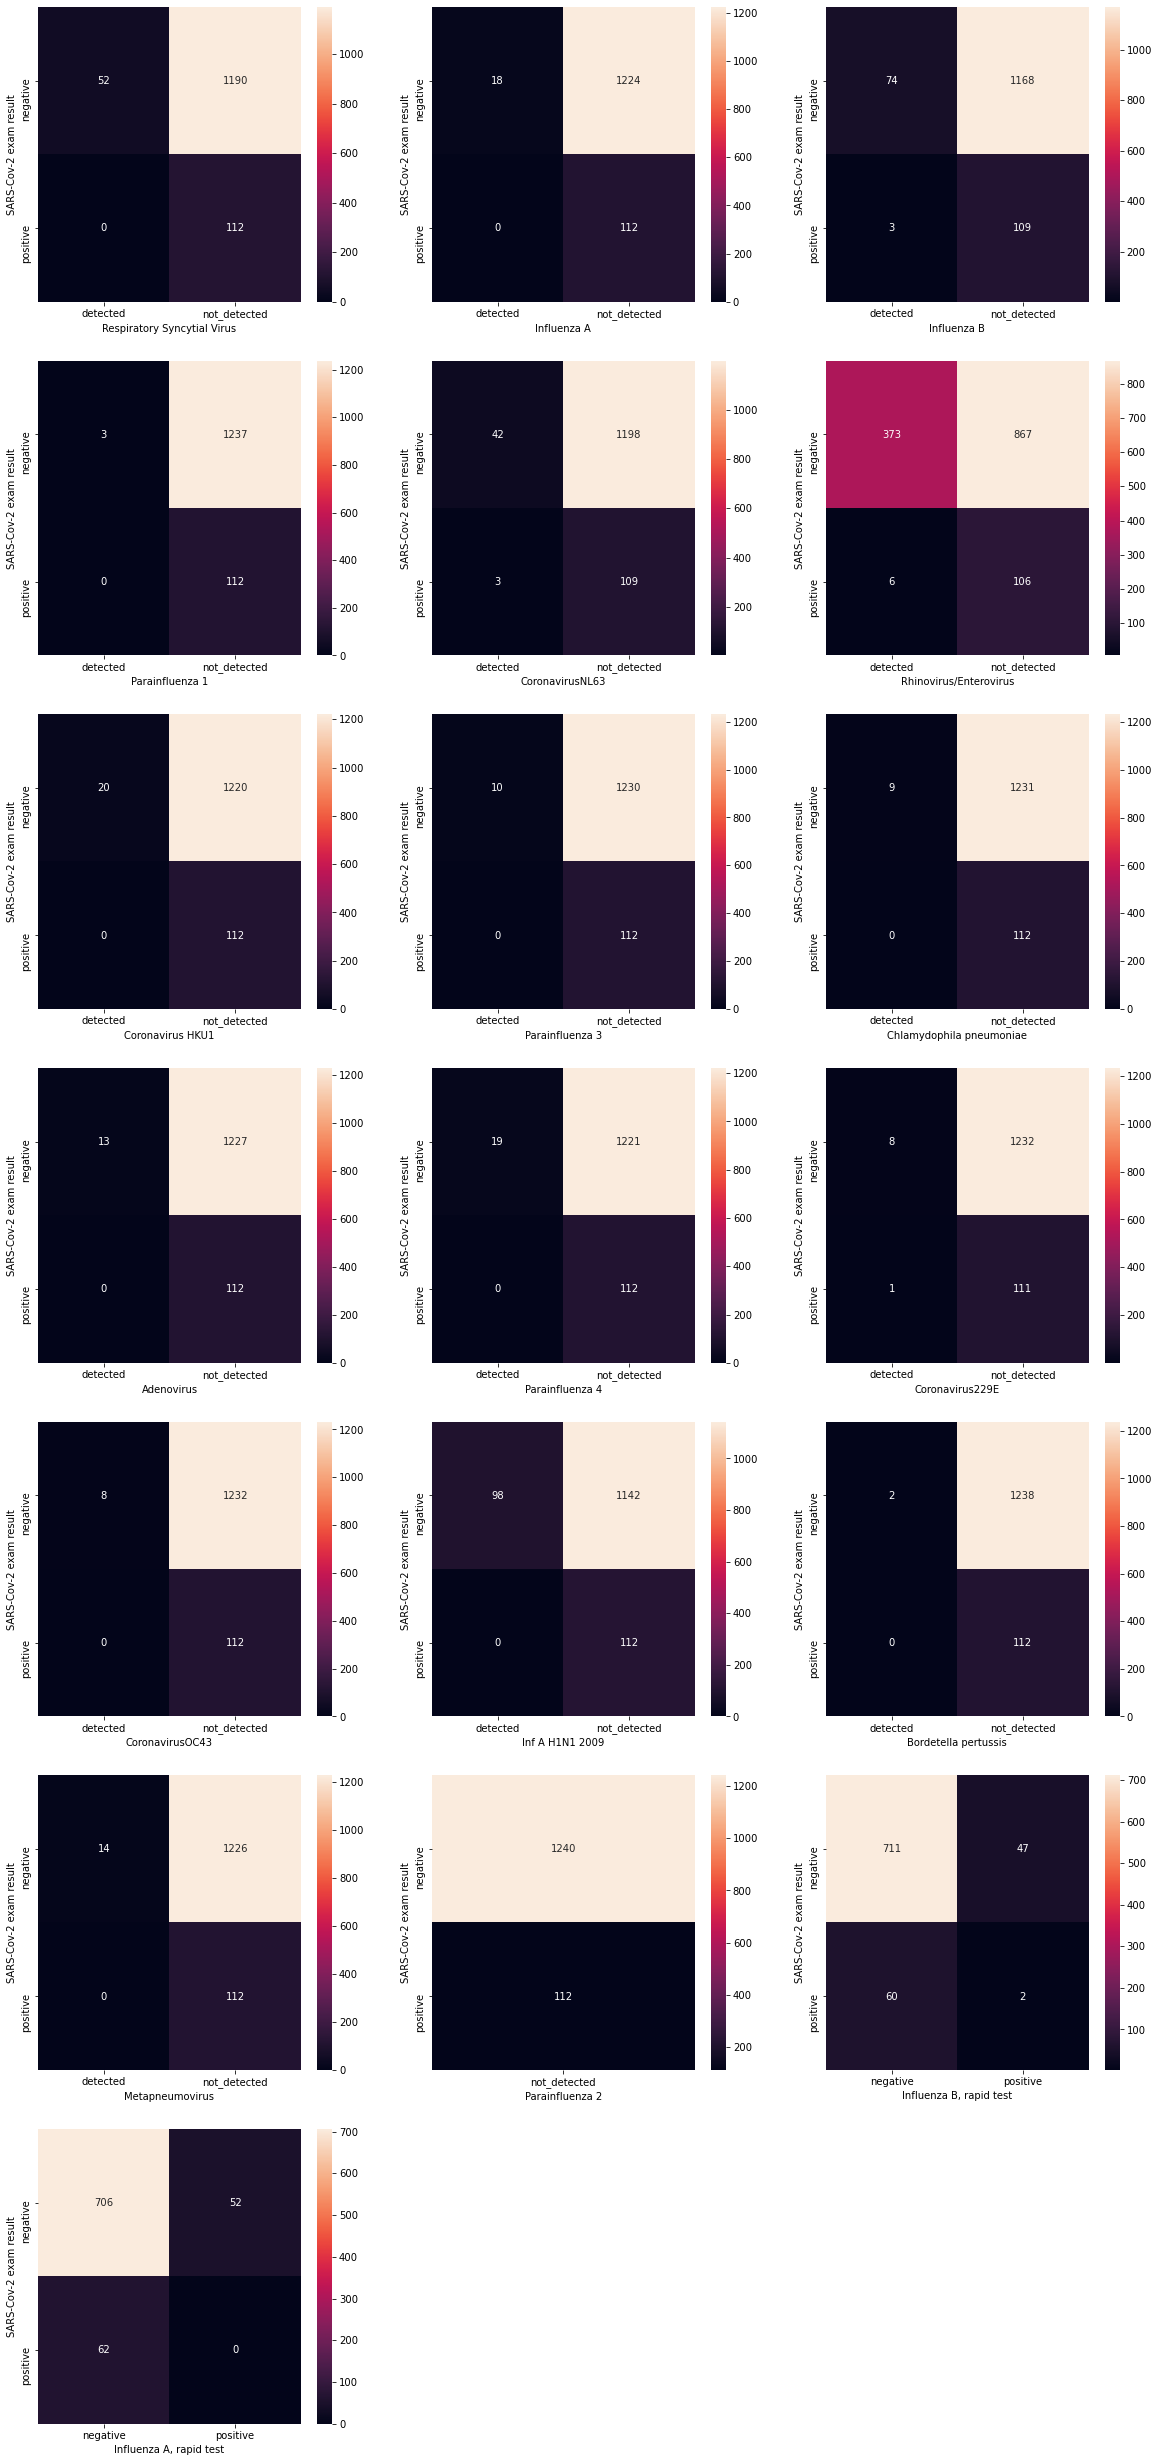

In [121]:
plt.figure(figsize=(20, 90))
for index, col in enumerate(viral_cols):
    plt.subplot(14,3, index+1)
    sns.heatmap(pd.crosstab(corona['SARS-Cov-2 exam result'], corona[col]), annot=True, fmt='d')
    index += 1

### Analyse features / features (à explorer)

### Test d'hypothèse d'(in)adéquation

On va utiliser le test de Student pour tester H0 : Les taux (moyens) de Platelets, Leukocytes et Monocytes SONT EGAUX chez les toutes les personnes, atteintes ou non du Coronavirus.

In [122]:
from scipy.stats import ttest_ind

In [123]:
# Check des proportions
covid_neg.shape, covid_pos.shape

((5086, 38), (558, 38))

In [124]:
# Sampling pour equilibrer les proportions
covid_neg_balanced = covid_neg.sample(558)
covid_neg_balanced.shape, covid_pos.shape

((558, 38), (558, 38))

In [134]:
# fonction de test d'hypothèse
def t_test(col):
    seuil = 0.02
    stat, p = ttest_ind(covid_neg_balanced[col].dropna(), covid_pos[col].dropna())
    
    if p < seuil:
        return 'H0 rejetée'
    else:
        return 0

In [135]:
for col in blood_cols:
    print(f'{col:-<50} {t_test(col)}')

Hematocrit---------------------------------------- H0 rejetée
Hemoglobin---------------------------------------- H0 rejetée
Platelets----------------------------------------- H0 rejetée
Mean platelet volume ----------------------------- 0
Red blood Cells----------------------------------- H0 rejetée
Lymphocytes--------------------------------------- 0
Mean corpuscular hemoglobin concentration (MCHC)-- 0
Leukocytes---------------------------------------- H0 rejetée
Basophils----------------------------------------- 0
Mean corpuscular hemoglobin (MCH)----------------- 0
Eosinophils--------------------------------------- H0 rejetée
Mean corpuscular volume (MCV)--------------------- 0
Monocytes----------------------------------------- H0 rejetée
Red blood cell distribution width (RDW)----------- 0


Effectivement, les Platelets, Leukocytes et Monocytes semblent être des variables SIGNIFICATIVEMENT differentes pour les personnes atteintes du Covid et les personnes non-atteintes. 

---

---

# III. Pre-processing

In [16]:
df = data.copy()

In [17]:
df.head()

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,...,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.02234,-0.517413,0.010677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df.shape

(5644, 111)

##  1ère feature selection suite à l'EDA

In [19]:
missing_rate = df.isna().sum()/df.shape[0]

In [20]:
# on elimine les col avec > 90% de NaN
viral_cols = list(df.columns[(missing_rate > 0.76) & (missing_rate < 0.89)])
blood_cols = list(df.columns[(missing_rate > 0.89) & (missing_rate < 0.9)])

# col importantes
key_cols = ['Patient age quantile', 'SARS-Cov-2 exam result']

In [21]:
df = df[key_cols + blood_cols + viral_cols]
df.shape

(5644, 35)

In [22]:
df.head()

,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,...,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,"Influenza B, rapid test","Influenza A, rapid test"
0,13,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17,negative,0.236515,-0.02234,-0.517413,0.010677,0.102004,0.318366,-0.95079,-0.09461,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative
2,8,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,NaN,NaN


## TrainTest

In [23]:
trainset, testset = train_test_split(df, train_size=0.8, random_state=0)

In [24]:
trainset['SARS-Cov-2 exam result'].value_counts(), testset['SARS-Cov-2 exam result'].value_counts()

(negative    4068
 positive     447
 Name: SARS-Cov-2 exam result, dtype: int64,
 negative    1018
 positive     111
 Name: SARS-Cov-2 exam result, dtype: int64)

## Encodage

In [25]:
def encodage(df):
    code = {
        'negative':0,
        'positive':1,
        'detected':1,
        'not detected':0}

    for col in df.select_dtypes('object').columns:
        df.loc[:,[col]] = df[col].map(code)
        
    return df

In [26]:
def imputation(df):
    #return df.dropna(axis=0) # PROBLEME : Il ne reste aucune donnée après Imputation : ne pas use now 
    return df.fillna(1)

In [27]:
def preprocessing(df):
    
    df = encodage(df)
    df = imputation(df)    
    
    X = df.drop('SARS-Cov-2 exam result', axis=1)
    y = df.loc[:, ['SARS-Cov-2 exam result']]
    
    print(y.value_counts())
    
    return X, y

In [28]:
X_train, y_train = preprocessing(trainset)

SARS-Cov-2 exam result
0                         4068
1                          447
dtype: int64


/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [29]:
X_test, y_test = preprocessing(testset)

SARS-Cov-2 exam result
0                         1018
1                          111
dtype: int64


---

## Modélisation

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [31]:
model = DecisionTreeClassifier(random_state=0)

In [39]:
# pipeline de 2e preprocessing pour sur les jeux de train et de test obtenus précédemment
preprocessor = make_pipeline(PolynomialFeatures(2, include_bias=False), SelectKBest(f_classif, k=10))

In [40]:
# creation des pipelines des modeles
DecisionTree = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=0))
RandomForest = make_pipeline(preprocessor, RandomForestClassifier(random_state=0))
SVC = make_pipeline(preprocessor, StandardScaler(), SVC())
KNN = make_pipeline(preprocessor, StandardScaler(), KNeighborsClassifier)

In [41]:
list_of_models = {'DecisionTree': DecisionTree,
                 'RandomForest': RandomForest,
                 'SVC': SVC,
                 'KNN': KNN
                 }

## Procédure d'évaluation

In [32]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

In [33]:
def evaluation(model):
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    N, train_score, val_score = learning_curve(model, X_train, y_train, 
                                              cv=4, scoring='f1',
                                              train_sizes=np.linspace(0.1, 1, 10))
    
    plt.figure()
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='val score')
    plt.legend()

------ DecisionTree ------
[[1011    7]
 [ 109    2]]
              precision    recall  f1-score   support

           0       0.90      0.99      0.95      1018
           1       0.22      0.02      0.03       111

    accuracy                           0.90      1129
   macro avg       0.56      0.51      0.49      1129
weighted avg       0.84      0.90      0.86      1129



/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31 439
 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 458 459
 460 461 462 463 464 465 466 467 468 469 470 471 472 473 476 477 478 479
 480 481 482 483 484 485 486 487 488 489 490 493 494 495 496 497 498 499
 500 501 502 503 504 505 506 509 510 511 512 513 514 515 516 517 518 519
 520 521 524 525 526 527 528 529 530 531 532 533 534 535 538 539 540 541
 542 543 544 545 546 547 548 551 552 553 554 555 556 557 558 559 560 563
 564 565 566 567 568 569 570 571 574 575 576 5

/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31 439
 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 458 459
 460 461 462 463 464 465 466 467 468 469 470 471 472 473 476 477 478 479
 480 481 482 483 484 485 486 487 488 489 490 493 494 495 496 497 498 499
 500 501 502 503 504 505 506 509 510 511 512 513 514 515 516 517 518 519
 520 521 524 525 526 527 528 529 530 531 532 533 534 535 538 539 540 541
 542 543 544 545 546 547 548 551 552 553 554 555 556 557 558 559 560 563
 564 565 566 567 568 569 570 571 574 575 576 577 578 579 580 581 584 585
 586 587 588 589 590 593 594 595 596 597 598 601 602 603 604 605 608 609
 610 611 614 615 616 619 620 623] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-p

/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31 439
 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 458 459
 460 461 462 463 464 465 466 467 468 469 470 471 472 473 476 477 478 479
 480 481 482 483 484 485 486 487 488 489 490 493 494 495 496 497 498 499
 500 501 502 503 504 505 506 509 510 511 512 513 514 515 516 517 518 519
 520 521 524 525 526 527 528 529 530 531 532 533 534 535 538 539 540 541
 542 543 544 545 546 547 548 551 552 553 554 555 556 557 558 559 560 563
 564 565 566 567 568 569 570 571 574 575 576 5

/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31 439
 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 458 459
 460 461 462 463 464 465 466 467 468 469 470 471 472 473 476 477 478 479
 480 481 482 483 484 485 486 487 488 489 490 493 494 495 496 497 498 499
 500 501 502 503 504 505 506 509 510 511 512 513 514 515 516 517 518 519
 520 521 524 525 526 527 528 529 530 531 532 533 534 535 538 539 540 541
 542 543 544 545 546 547 548 551 552 553 554 555 556 557 558 559 560 563
 564 565 566 567 568 569 570 571 574 575 576 5

/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31 439
 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 458 459
 460 461 462 463 464 465 466 467 468 469 470 471 472 473 476 477 478 479
 480 481 482 483 484 485 486 487 488 489 490 493 494 495 496 497 498 499
 500 501 502 503 504 505 506 509 510 511 512 513 514 515 516 517 518 519
 520 521 524 525 526 527 528 529 530 531 532 533 534 535 538 539 540 541
 542 543 544 545 546 547 548 551 552 553 554 555 556 557 558 559 560 563
 564 565 566 567 568 569 570 571 574 575 576 5

/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31 439
 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 458 459
 460 461 462 463 464 465 466 467 468 469 470 471 472 473 476 477 478 479
 480 481 482 483 484 485 486 487 488 489 490 493 494 495 496 497 498 499
 500 501 502 503 504 505 506 509 510 511 512 513 514 515 516 517 518 519
 520 521 524 525 526 527 528 529 530 531 532 533 534 535 538 539 540 541
 542 543 544 545 546 547 548 551 552 553 554 555 556 557 558 559 560 563
 564 565 566 567 568 569 570 571 574 575 576 577 578 579 580 581 584 585
 586 587 588 589 590 593 594 595 596 597 598 601 602 603 604 605 608 609
 610 611 614 615 616 619 620 623] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-p

------ RandomForest ------
[[1010    8]
 [ 109    2]]
              precision    recall  f1-score   support

           0       0.90      0.99      0.95      1018
           1       0.20      0.02      0.03       111

    accuracy                           0.90      1129
   macro avg       0.55      0.51      0.49      1129
weighted avg       0.83      0.90      0.86      1129



/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31 439
 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 458 459
 460 461 462 463 464 465 466 467 468 469 470 471 472 473 476 477 478 479
 480 481 482 483 484 485 486 487 488 489 490 493 494 495 496 497 498 499
 500 501 502 503 504 505 506 509 510 511 512 513 514 515 516 517 518 519
 520 521 524 525 526 527 528 529 530 531 532 533 534 535 538 539 540 541
 542 543 544 545 546 547 548 551 552 553 554 555 556 557 558 559 560 563
 564 565 566 567 568 569 570 571 574 575 576 5

/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31 439
 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 458 459
 460 461 462 463 464 465 466 467 468 469 470 471 472 473 476 477 478 479
 480 481 482 483 484 485 486 487 488 489 490 493 494 495 496 497 498 499
 500 501 502 503 504 505 506 509 510 511 512 513 514 515 516 517 518 519
 520 521 524 525 526 527 528 529 530 531 532 533 534 535 538 539 540 541
 542 543 544 545 546 547 548 551 552 553 554 555 556 557 558 559 560 563
 564 565 566 567 568 569 570 571 574 575 576 5

/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31 439
 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 458 459
 460 461 462 463 464 465 466 467 468 469 470 471 472 473 476 477 478 479
 480 481 482 483 484 485 486 487 488 489 490 493 494 495 496 497 498 499
 500 501 502 503 504 505 506 509 510 511 512 513 514 515 516 517 518 519
 520 521 524 525 526 527 528 529 530 531 532 533 534 535 538 539 540 541
 542 543 544 545 546 547 548 551 552 553 554 555 556 557 558 559 560 563
 564 565 566 567 568 569 570 571 574 575 576 5

/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31 439
 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 458 459
 460 461 462 463 464 465 466 467 468 469 470 471 472 473 476 477 478 479
 480 481 482 483 484 485 486 487 488 489 490 493 494 495 496 497 498 499
 500 501 502 503 504 505 506 509 510 511 512 513 514 515 516 517 518 519
 520 521 524 525 526 527 528 529 530 531 532 533 534 535 538 539 540 541
 542 543 544 545 546 547 548 551 552 553 554 555 556 557 558 559 560 563
 564 565 566 567 568 569 570 571 574 575 576 577 578 579 580 581 584 585
 586 587 588 589 590 593 594 595 596 597 598 601 602 603 604 605 608 609
 610 611 614 615 616 619 620 623] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-p

/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31 439
 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 458 459
 460 461 462 463 464 465 466 467 468 469 470 471 472 473 476 477 478 479
 480 481 482 483 484 485 486 487 488 489 490 493 494 495 496 497 498 499
 500 501 502 503 504 505 506 509 510 511 512 513 514 515 516 517 518 519
 520 521 524 525 526 527 528 529 530 531 532 533 534 535 538 539 540 541
 542 543 544 545 546 547 548 551 552 553 554 555 556 557 558 559 560 563
 564 565 566 567 568 569 570 571 574 575 576 5

/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31 439
 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 458 459
 460 461 462 463 464 465 466 467 468 469 470 471 472 473 476 477 478 479
 480 481 482 483 484 485 486 487 488 489 490 493 494 495 496 497 498 499
 500 501 502 503 504 505 506 509 510 511 512 513 514 515 516 517 518 519
 520 521 524 525 526 527 528 529 530 531 532 533 534 535 538 539 540 541
 542 543 544 545 546 547 548 551 552 553 554 555 556 557 558 559 560 563
 564 565 566 567 568 569 570 571 574 575 576 577 578 579 580 581 584 585
 586 587 588 589 590 593 594 595 596 597 598 601 602 603 604 605 608 609
 610 611 614 615 616 619 620 623] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-p

/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31 439
 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 458 459
 460 461 462 463 464 465 466 467 468 469 470 471 472 473 476 477 478 479
 480 481 482 483 484 485 486 487 488 489 490 493 494 495 496 497 498 499
 500 501 502 503 504 505 506 509 510 511 512 513 514 515 516 517 518 519
 520 521 524 525 526 527 528 529 530 531 532 533 534 535 538 539 540 541
 542 543 544 545 546 547 548 551 552 553 554 555 556 557 558 559 560 563
 564 565 566 567 568 569 570 571 574 575 576 5

/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31 439
 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 458 459
 460 461 462 463 464 465 466 467 468 469 470 471 472 473 476 477 478 479
 480 481 482 483 484 485 486 487 488 489 490 493 494 495 496 497 498 499
 500 501 502 503 504 505 506 509 510 511 512 513 514 515 516 517 518 519
 520 521 524 525 526 527 528 529 530 531 532 533 534 535 538 539 540 541
 542 543 544 545 546 547 548 551 552 553 554 555 556 557 558 559 560 563
 564 565 566 567 568 569 570 571 574 575 576 577 578 579 580 581 584 585
 586 587 588 589 590 593 594 595 596 597 598 601 602 603 604 605 608 609
 610 611 614 615 616 619 620 623] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-p

------ SVC ------


/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31 439
 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 458 459
 460 461 462 463 464 465 466 467 468 469 470 471 472 473 476 477 478 479
 480 481 482 483 484 485 486 487 488 489 490 493 494 495 496 497 498 499
 500 501 502 503 504 505 506 509 510 511 512 513 514 515 516 517 518 519
 520 521 524 525 526 527 528 529 530 531 532 533 534 535 538 539 540 541
 542 543 544 545 546 547 548 551 552 553 554 555 556 557 558 559 560 563
 564 565 566 567 568 569 570 571 574 575 576 5

[[1015    3]
 [ 111    0]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1018
           1       0.00      0.00      0.00       111

    accuracy                           0.90      1129
   macro avg       0.45      0.50      0.47      1129
weighted avg       0.81      0.90      0.85      1129



/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31 439
 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 458 459
 460 461 462 463 464 465 466 467 468 469 470 471 472 473 476 477 478 479
 480 481 482 483 484 485 486 487 488 489 490 493 494 495 496 497 498 499
 500 501 502 503 504 505 506 509 510 511 512 513 514 515 516 517 518 519
 520 521 524 525 526 527 528 529 530 531 532 533 534 535 538 539 540 541
 542 543 544 545 546 547 548 551 552 553 554 555 556 557 558 559 560 563
 564 565 566 567 568 569 570 571 574 575 576 5

/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31 439
 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 458 459
 460 461 462 463 464 465 466 467 468 469 470 471 472 473 476 477 478 479
 480 481 482 483 484 485 486 487 488 489 490 493 494 495 496 497 498 499
 500 501 502 503 504 505 506 509 510 511 512 513 514 515 516 517 518 519
 520 521 524 525 526 527 528 529 530 531 532 533 534 535 538 539 540 541
 542 543 544 545 546 547 548 551 552 553 554 555 556 557 558 559 560 563
 564 565 566 567 568 569 570 571 574 575 576 5

/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31 439
 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 458 459
 460 461 462 463 464 465 466 467 468 469 470 471 472 473 476 477 478 479
 480 481 482 483 484 485 486 487 488 489 490 493 494 495 496 497 498 499
 500 501 502 503 504 505 506 509 510 511 512 513 514 515 516 517 518 519
 520 521 524 525 526 527 528 529 530 531 532 533 534 535 538 539 540 541
 542 543 544 545 546 547 548 551 552 553 554 555 556 557 558 559 560 563
 564 565 566 567 568 569 570 571 574 575 576 5

/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31 439
 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 458 459
 460 461 462 463 464 465 466 467 468 469 470 471 472 473 476 477 478 479
 480 481 482 483 484 485 486 487 488 489 490 493 494 495 496 497 498 499
 500 501 502 503 504 505 506 509 510 511 512 513 514 515 516 517 518 519
 520 521 524 525 526 527 528 529 530 531 532 533 534 535 538 539 540 541
 542 543 544 545 546 547 548 551 552 553 554 555 556 557 558 559 560 563
 564 565 566 567 568 569 570 571 574 575 576 5

/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31 439
 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 458 459
 460 461 462 463 464 465 466 467 468 469 470 471 472 473 476 477 478 479
 480 481 482 483 484 485 486 487 488 489 490 493 494 495 496 497 498 499
 500 501 502 503 504 505 506 509 510 511 512 513 514 515 516 517 518 519
 520 521 524 525 526 527 528 529 530 531 532 533 534 535 538 539 540 541
 542 543 544 545 546 547 548 551 552 553 554 555 556 557 558 559 560 563
 564 565 566 567 568 569 570 571 574 575 576 5

/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31 439
 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 458 459
 460 461 462 463 464 465 466 467 468 469 470 471 472 473 476 477 478 479
 480 481 482 483 484 485 486 487 488 489 490 493 494 495 496 497 498 499
 500 501 502 503 504 505 506 509 510 511 512 513 514 515 516 517 518 519
 520 521 524 525 526 527 528 529 530 531 532 533 534 535 538 539 540 541
 542 543 544 545 546 547 548 551 552 553 554 555 556 557 558 559 560 563
 564 565 566 567 568 569 570 571 574 575 576 577 578 579 580 581 584 585
 586 587 588 589 590 593 594 595 596 597 598 601 602 603 604 605 608 609
 610 611 614 615 616 619 620 623] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-p

/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31 439
 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 458 459
 460 461 462 463 464 465 466 467 468 469 470 471 472 473 476 477 478 479
 480 481 482 483 484 485 486 487 488 489 490 493 494 495 496 497 498 499
 500 501 502 503 504 505 506 509 510 511 512 513 514 515 516 517 518 519
 520 521 524 525 526 527 528 529 530 531 532 533 534 535 538 539 540 541
 542 543 544 545 546 547 548 551 552 553 554 555 556 557 558 559 560 563
 564 565 566 567 568 569 570 571 574 575 576 577 578 579 580 581 584 585
 586 587 588 589 590 593 594 595 596 597 598 601 602 603 604 605 608 609
 610 611 614 615 616 619 620 623] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-p

------ KNN ------


/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/jean-martial/opt/anaconda3/envs/MS_BIGDATA/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31 439
 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 458 459
 460 461 462 463 464 465 466 467 468 469 470 471 472 473 476 477 478 479
 480 481 482 483 484 485 486 487 488 489 490 493 494 495 496 497 498 499
 500 501 502 503 504 505 506 509 510 511 512 513 514 515 516 517 518 519
 520 521 524 525 526 527 528 529 530 531 532 533 534 535 538 539 540 541
 542 543 544 545 546 547 548 551 552 553 554 555 556 557 558 559 560 563
 564 565 566 567 568 569 570 571 574 575 576 5

TypeError: fit() missing 1 required positional argument: 'y'

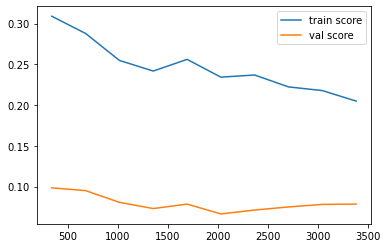

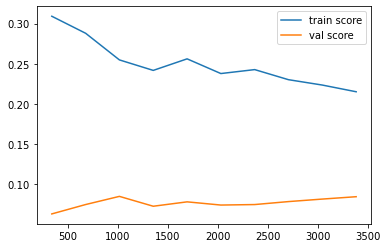

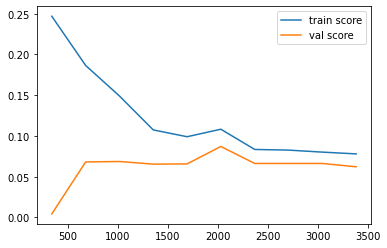

In [42]:
for name, model in list_of_models.items():
    print('------', name, '------')
    evaluation(model)

## Optimisation

In [53]:
SVC

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('polynomialfeatures',
                                  PolynomialFeatures(include_bias=False)),
                                 ('selectkbest', SelectKBest())])),
                ('standardscaler', StandardScaler()), ('svc', SVC())])